Fit CNN in PyTorch
===


## Imports

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets, models, transforms, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import cv2
from skimage import io, transform


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# number of models
n_ensemble = 2

# Number of dimensions in the dataset
n_dim = 8

# Batch size for training (change depending on how much memory you have)
batch_size_im = 90
batch_size_ft = 30

# Number of epochs to train for 
num_epochs_im = 10 # overall needs 100
num_epochs_ft = 10

# where would we use these in pytorch? in keras they are used to create layers for the intermediate model
dropout = 0.5   
n_dense = 256
n_layers = 2

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract_im = True
feature_extract_ft = False

input_size = 224

loglr = -2.2200654426745987
lr_im = 10 ** loglr
lr_ft = 0.0001

img_dir = "../sanders_2018/360 Rocks"
csv_file = "../finetuning_torchvision_data/mds_360.csv"
PATH_IM = 'CNN_checkpoints/state_dict_intermediate_model.pt'

## Functions and classes

In [96]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=14, is_inception=False):
    """
    handles the training and validation of a given model. At the end of
    training returns the best performing model. After each epoch, the training and validation
    accuracies are printed
    """
    
    since = time.time()

    val_acc_history = []
    lrs = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = None
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_r2 = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    score = r2_score(labels.detach().numpy(), outputs.detach().numpy())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        lr = optimizer.param_groups[0]["lr"]
                        lrs.append(lr)

                # statistics 
                running_loss += loss.item() * inputs.size(0)
                running_r2 += score.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset) 
            epoch_acc = running_r2 / len(dataloaders[phase].dataset) 

            print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc: .4f} lr: {lr: .4e}')

            # deep copy the model
            if phase == 'val' and best_acc == None:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and best_acc < epoch_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        
        print() # empty line between epochs

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, lrs


def set_parameter_requires_grad(model, feature_extracting):
    """
    This helper function sets the ``.requires_grad`` attribute of the
    parameters in the model to False when we are feature extracting.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True
    return None


class RocksData(Dataset):
    def __init__(self, df, root_dir):
        super(RocksData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        self.root_dir = root_dir
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]
        img = cv2.imread(img_path)/255.
        kp = deepcopy(self.df.iloc[ix,1:].tolist())
#        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
#        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
#        kp2 = kp_x + kp_y
#        kp2 = torch.tensor(kp2) 
        kp = torch.tensor(kp) 
        img = self.preprocess_input(img)
        return img, kp.float()
    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)
    def load_img(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]        
        img = cv2.imread(img_path)
        img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img
    

def get_criterion(loss_name):
    """
    Returns the optimizer
    """
    if loss_name == "L1":
        return torch.nn.L1Loss()
    elif loss_name == "L2":
        return torch.nn.MSELoss()
    elif loss_name == "smooth_L1":
        return torch.nn.SmoothL1Loss()
    elif loss_name == "huber":
        return torch.nn.HuberLoss()
    else:
        raise Exception("No valid loss_name entered!")

## Load Data

In [97]:
df = pd.read_csv(csv_file)

train, test = train_test_split(df, test_size=90, random_state=0)
train_dataset = RocksData(train.reset_index(drop=True), img_dir)
test_dataset = RocksData(test.reset_index(drop=True), img_dir)

## Define final layers

This is how the final layers look like in Keras:

```
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================

avg_pool (GlobalAveragePooling  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 2D)                                                                                              
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['avg_pool[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['dropout[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256)         1024        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout_1 (Dropout)            (None, 256)          0           ['batch_normalization[0][0]']    
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dropout_1[0][0]']              
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256)         1024        ['dense_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dropout_2 (Dropout)            (None, 256)          0           ['batch_normalization_1[0][0]']  
                                                                                                  
 dense_2 (Dense)                (None, 8)            2056        ['dropout_2[0][0]']       
```

In [98]:
def get_output_layers(dropout, num_ftrs, n_dim, n_layers):
    """
    Returns the output layers.
    """
   
    output = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_ftrs, n_dense), # dense in keras
            nn.ReLU(inplace=True), # dense
            nn.BatchNorm1d(n_dense),
            nn.Dropout(p=dropout),
            nn.Linear(n_dense, n_dense), # dense
            nn.ReLU(inplace=True), # dense
            nn.BatchNorm1d(n_dense),
            nn.Dropout(p=dropout),
            nn.Linear(n_dense, n_dim) # dense
        )
    
    return output

## Train intermediate model only

In [99]:
# Intermediate model
model = models.resnet50(pretrained=True)
set_parameter_requires_grad(model, feature_extract_im)
num_ftrs = model.fc.in_features
new_layers = get_output_layers(dropout, num_ftrs, n_dim, n_layers)
model.fc = new_layers # last fully connected layer
    
# OPTIONAL: Load pre-trained state
# checkpoint = torch.load(PATH_IM)
# model.load_state_dict(checkpoint['model_state_dict'])

# Send the model to GPU
model = model.to(device)

# create datalaoders with specific batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size_im)
test_loader = DataLoader(test_dataset, batch_size=batch_size_im)
dataloaders_dict = {"train":train_loader,"val":test_loader}

# Create Optimizer and define params to update
params_to_update = model.parameters()
print('Params to learn for intermediate training:')
if feature_extract_im:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Instantiate optimizer for intermediate model
optimizer = optim.Adam(params_to_update, lr = lr_im)
# OPTIONAL: load saved state
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# override the last learning rate
# for param in optimizer.param_groups:
#    param['lr'] = lr_im

# Setup the loss fxn
criterion = get_criterion('L2')

# Initial training and evaluate
model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs_im)

# Plot learning curve
plt.plot(hist)
plt.title('Intermediate model')
plt.show()

Params to learn for intermediate training:
	 fc.1.weight
	 fc.1.bias
	 fc.3.weight
	 fc.3.bias
	 fc.5.weight
	 fc.5.bias
	 fc.7.weight
	 fc.7.bias
	 fc.9.weight
	 fc.9.bias
Epoch 1/10
----------
score -0.13192060229189106
score 0.007417307363264972
score 0.08747605482523546
train Loss:  6.5258 Acc: -0.0123 lr:  6.0247e-03
score 0.0750553199888842
val Loss:  6.0611 Acc:  0.0751 lr:  6.0247e-03

Epoch 2/10
----------
score 0.268774765430937
score 0.3035930414537027
score 0.3706037374417188
train Loss:  4.2152 Acc:  0.3143 lr:  6.0247e-03
score 0.1522307821054082
val Loss:  5.4563 Acc:  0.1522 lr:  6.0247e-03

Epoch 3/10
----------
score 0.4150664410801096
score 0.36968081145267634
score 0.42197292236340067
train Loss:  3.6830 Acc:  0.4022 lr:  6.0247e-03
score 0.13848539095091708
val Loss:  5.3399 Acc:  0.1385 lr:  6.0247e-03

Epoch 4/10
----------
score 0.4554848225852163
score 0.46761633170227723
score 0.5057341726616975
train Loss:  3.2368 Acc:  0.4763 lr:  6.0247e-03
score 0.26290672

KeyboardInterrupt: 

In [54]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH_IM)

check results for an example rock ...
... to compare with keras results

In [55]:
model.eval();

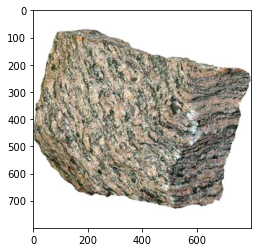

In [64]:
from PIL import Image
import matplotlib.pyplot as plt

img_dir = '../sanders_2018/360 Rocks'
img = Image.open(img_dir + "/" + df.iloc[145, 0])
img = np.array(img)
imgt = img.reshape(1, 3, 800, 800)
imgt = torch.Tensor(imgt)

plt.imshow(img.squeeze());

In [65]:
pred = model(imgt)
pred

tensor([[-223.1959,   58.8754,   71.4745,  418.2480,  147.6133,  -68.1055,
          -75.9532, -128.8544]], grad_fn=<AddmmBackward0>)

In [69]:
last_inputt = last_input.reshape(1, 3, 224, 224)
last_inputt = torch.Tensor(last_inputt)

In [72]:
last_label

array([ 1.60399997,  4.17199993,  1.00999999, -2.67499995,  2.329     ,
       -0.154     ,  0.042     ,  1.76900005])

In [71]:
model(last_inputt)

tensor([[-0.7486,  0.5832,  0.6784,  0.2209,  0.6118, -0.1595,  0.0092, -0.0948]],
       grad_fn=<AddmmBackward0>)

In [58]:
mean_squared_error(y_test_0, pred.detach().numpy().squeeze())

NameError: name 'y_test_0' is not defined

In [59]:
last_label = np.loadtxt("last_label")
last_output = np.loadtxt("last_output")
last_input = np.loadtxt("last_input")

last_input = last_input.reshape(224, 224, 3)

In [73]:
r2_score(last_label,last_output)

0.414824861492492

In [63]:
last_output

array([ 0.64417177,  0.57285661,  1.62637281, -2.66687512,  2.37102556,
       -0.84005195,  0.55305833,  0.46092996])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


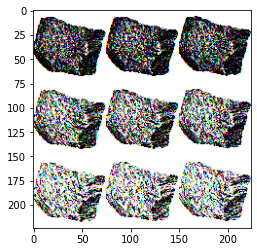

In [60]:
plt.imshow(last_input)

In [61]:
df[df.image_name == "M_Gneiss_02.jpg"]

,image_name,1,2,3,4,5,6,7,8
145,M_Gneiss_02.jpg,1.604,4.172,1.01,-2.675,2.329,-0.154,0.042,1.769


but then ...what happened to the labels?? why did they get transformed so bad???

## Train finetuned model only

In [ ]:
# Load intermediate model for finetuning
model = models.resnet50(pretrained=True)
set_parameter_requires_grad(model, feature_extract_ft)
num_ftrs = model.fc.in_features
new_layers = get_output_layers(dropout, num_ftrs, n_dim, n_layers)
model.fc = new_layers # last fully connected layer
    
# OPTIONAL: Load pre-trained state
checkpoint = torch.load(PATH_IM)
model.load_state_dict(checkpoint['model_state_dict'])

# Send the model to GPU
model = model.to(device)

# create datalaoders with specific batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size_ft)
test_loader = DataLoader(test_dataset, batch_size=batch_size_ft)
dataloaders_dict = {"train":train_loader,"val":test_loader}

# Create Optimizer and define params to update
params_to_update = model.parameters()
print('Params to learn for finetuning:')
if feature_extract_ft:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Instantiate optimizer for finetuning
optimizer = optim.SGD(params_to_update, lr = lr_ft, momentum = 0.9)

# Setup the loss fxn
criterion = get_criterion("L2")

# Train and evaluate fine tuned model
model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs_ft)

# Plot learning curve
plt.plot(hist)
plt.title('Finetuned model')
plt.show()

# Save intermediate model
PATH_EN = 'CNN_checkpoints/state_dict_finetuned_model.pt'
torch.save(model.state_dict(), PATH_EN)

## Train ensemble

In [ ]:
for e in range(1, n_ensemble + 1):
       
    # Intermediate model
    model = models.resnet50(pretrained=True)
    set_parameter_requires_grad(model, feature_extract_im)
    num_ftrs = model.fc.in_features
    new_layers = get_output_layers(dropout, num_ftrs, n_dim, n_layers)
    model.fc = new_layers # last fully connected layer
    
    # Send the model to GPU
    model = model.to(device)
    
    # create datalaoders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size_im)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_im)
    dataloaders_dict = {"train":train_loader,"val":test_loader}
    
    # Create Optimizer and define params to update
    params_to_update = model.parameters()
    print('Params to learn for intermediate training:')
    if feature_extract_im:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Instantiate optimizer for intermediate model
    optimizer = optim.Adam(params_to_update, lr = lr_im)
    
    # Setup the loss fxn
    criterion = get_criterion('L2')
    
    # Initial training and evaluate
    model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs_im)
    
    # Plot learning curve
    plt.plot(hist)
    plt.title('Intermediate model')
    plt.show()
    
    # Save intermediate model
    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, PATH_IM)

    # fine tuning
    
    # create datalaoders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size_ft)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_ft)
    dataloaders_dict = {"train":train_loader,"val":test_loader}
            
    # Create Optimizer and define params to update
    params_to_update = model.parameters()
    print('Params to learn for finetuning:')
    if feature_extract_ft:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Instantiate optimizer for finetuning
    optimizer = optim.SGD(params_to_update, lr = lr_ft, momentum = 0.9)
    
    # Setup the loss fxn
    criterion = get_criterion("L2")

    # Train and evaluate fine tuned model
    model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs_ft)
    
    # Plot learning curve
    plt.plot(hist)
    plt.title(f'Ensemble model {e}')
    plt.show()
    
    # Save intermediate model
    PATH_EN = f'CNN_checkpoints/state_dict_ensemble_model_{e}.pt'
    torch.save(model.state_dict(), PATH_EN)